# Drive mounting

In [1]:
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Importing libraries

In [2]:
!pip install --upgrade tables

     |████████████████████████████████| 4.3MB 3.9MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [3]:
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import RobustScaler
from tensorflow import keras
import missingno as msno

# 2. Data loading 

## 2.1 Data loading standard way

In [4]:
train = pd.read_hdf('/content/drive/MyDrive/time-series/retail/train_online_retail.h5')
test = pd.read_hdf('/content/drive/MyDrive/time-series/retail/test_online_retail.h5')

In [5]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       520142 non-null  int32         
 1   stock_code    520142 non-null  int16         
 2   description   517903 non-null  object        
 3   quantity      520142 non-null  int32         
 4   invoice_date  520142 non-null  datetime64[ns]
 5   price_unit    520142 non-null  float16       
 6   price_total   520142 non-null  float32       
 7   customer_id   520142 non-null  int16         
 8   country       520142 non-null  object        
 9   is_canceled   520142 non-null  bool          
 10  is_test       520142 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 25.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 547229 entries, 0 to 541893
Data columns (total 10 columns):
 

(None, None)

### Lets display a bit and see what is inside

In [6]:
time_info='invoice_date'

In [7]:
def gen_time_features(orders, time_info):

  orders["date"] = orders[time_info].astype("datetime64")
  orders['year'] = orders['date'].dt.year
  orders['month'] = orders['date'].dt.month
  orders['weekday'] = orders['date'].dt.weekday
  orders['hour'] = orders['date'].dt.hour
  orders['week'] = orders['date'].dt.isocalendar().week
  return orders

In [8]:
train= gen_time_features(train, time_info)

In [9]:
train.sample(7)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test,date,year,month,weekday,hour,week
19831,978,769,RED SPOTTY CHILDS APRON,4,2009-12-09 09:42:00,4.300781,17.200001,-1,United Kingdom,False,False,2009-12-09 09:42:00,2009,12,2,9,50
479244,26631,698,SET OF 72 RETROSPOT PAPER DOILIES,2,2010-11-22 12:44:00,1.450195,2.900000,3869,United Kingdom,False,False,2010-11-22 12:44:00,2010,11,0,12,47
52329,2710,1132,BEADED CRYSTAL HEART PINK SMALL,1,2010-01-12 09:47:00,2.509766,2.510000,-1,United Kingdom,False,False,2010-01-12 09:47:00,2010,1,1,9,2
95204,5258,324,NO SINGING METAL SIGN,12,2010-02-18 14:25:00,2.099609,25.200001,1680,United Kingdom,False,False,2010-02-18 14:25:00,2010,2,3,14,7
142180,34613,1319,JIGSAW TREE WITH BIRDHOUSE,12,2011-04-01 10:05:00,1.450195,17.400000,4296,United Kingdom,False,False,2011-04-01 10:05:00,2011,4,4,10,13
324932,44397,4249,RECIPE BOX PANTRY YELLOW DESIGN,1,2011-09-04 12:41:00,2.949219,2.950000,3333,United Kingdom,False,False,2011-09-04 12:41:00,2011,9,6,12,35
324522,44378,4001,MAGIC DRAWING SLATE DINOSAUR,3,2011-09-04 11:00:00,0.419922,1.260000,3499,United Kingdom,False,False,2011-09-04 11:00:00,2011,9,6,11,35


In [10]:
train.groupby('customer_id').mean()

,invoice,stock_code,quantity,price_unit,price_total,is_canceled,is_test,year,month,weekday,hour,week
customer_id,,,,,,,,,,,,
-1,28408.608052,1990.442781,6.757912,9.546875,15.439903,0.002728,0.0,2010.443434,7.313083,1.905794,13.580860,29.755380
0,33053.142857,2210.809524,13.380952,42.062500,59.615238,0.380952,0.0,2010.952381,3.047619,3.047619,14.095238,11.952381
1,26465.803279,1660.275956,15.183060,4.066406,35.301529,0.081967,0.0,2010.327869,7.822404,2.412568,12.579235,32.133880
2,8423.950000,605.225000,9.200000,3.611328,15.327000,0.000000,0.0,2009.425000,10.725000,2.275000,9.425000,43.900000
3,27627.415663,2302.016064,159.588353,4.144531,541.268982,0.006024,0.0,2010.417671,7.542169,1.953815,12.985944,30.630522
...,...,...,...,...,...,...,...,...,...,...,...,...
5930,53196.000000,3195.303030,19.454545,0.585449,9.473333,0.000000,0.0,2011.000000,12.000000,1.000000,11.000000,49.000000
5935,53292.000000,2315.041667,10.000000,2.451172,7.026250,0.000000,0.0,2011.000000,12.000000,1.000000,17.000000,49.000000
5936,53342.500000,5182.000000,385.000000,8.328125,2024.250000,0.000000,0.0,2011.000000,12.000000,2.000000,12.000000,49.000000


In [11]:
train.groupby('customer_id').sum()

,invoice,stock_code,quantity,price_unit,price_total,is_canceled,is_test,year,month,weekday,hour,week
customer_id,,,,,,,,,,,,
-1,3.176026e+09,222527522.0,755521.0,inf,1.726150e+06,305,0,224763555,817588,213064,1518313,3326592
0,6.941160e+05,46427.0,281.0,883.500000,1.251920e+03,8,0,42230,64,64,296,251
1,9.686484e+06,607661.0,5557.0,1488.000000,1.292036e+04,30,0,735780,2863,883,4604,11761
2,3.369580e+05,24209.0,368.0,144.500000,6.130800e+02,0,0,80377,429,91,377,1756
3,1.375845e+07,1146404.0,79475.0,2064.000000,2.695519e+05,3,0,1001188,3756,973,6467,15254
...,...,...,...,...,...,...,...,...,...,...,...,...
5930,1.755468e+06,105445.0,642.0,19.328125,3.126200e+02,0,0,66363,396,33,363,1617
5935,1.279008e+06,55561.0,240.0,58.812500,1.686300e+02,0,0,48264,288,24,408,1176
5936,1.066850e+05,10364.0,770.0,16.656250,4.048500e+03,0,0,4022,24,4,24,98


In [12]:
train.groupby('year').mean()

,invoice,stock_code,quantity,price_unit,price_total,customer_id,is_canceled,is_test,month,weekday,hour,week
year,,,,,,,,,,,,
2009,1089.402085,828.524690,10.186714,4.363281,19.205385,309.596100,0.022833,0.0,12.000000,2.191779,13.467924,50.133789
2010,16982.128064,1721.492197,12.431299,5.390625,21.288288,1246.374914,0.020498,0.0,7.326510,2.558513,12.934823,29.636717
2011,42317.291415,2604.843940,12.126052,4.789062,22.531723,1886.198696,0.017418,0.0,7.189698,2.432705,12.957672,29.220905


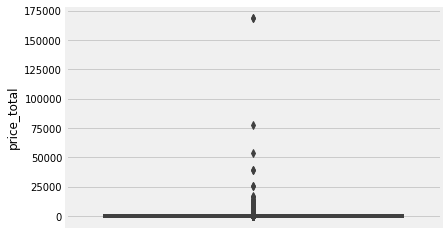

In [13]:
sns.boxplot(y=train['price_total']);

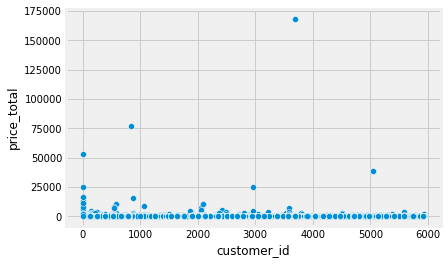

In [14]:
sns.scatterplot(x = "customer_id", y = "price_total", data = train);

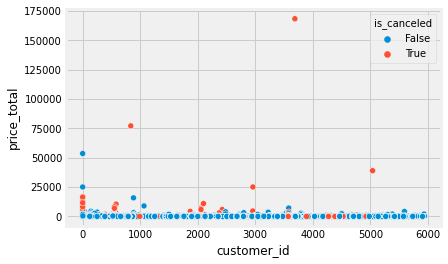

In [15]:
sns.scatterplot(x = "customer_id", y = "price_total", data = train, hue='is_canceled');

It looks like above 25000 thous there are outliers

https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
https://androidkt.com/detect-and-remove-outliers-from-pandas-dataframe/

In [16]:
#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out



In [17]:
def remove_outlier(df_in, col_name, low):

    print('percetaile removed below/above --->{}/ {}'.format(low*100, 100-low*100))
    q1 = df_in[col_name].quantile(low)
    q3 = df_in[col_name].quantile(1-low)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    sns.boxplot(y=df_out[col_name]);

    return df_out

percetaile removed below/above --->20.0/ 80.0


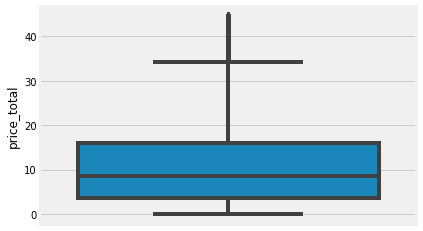

In [18]:
low= 0.2
col_name='price_total'
train= remove_outlier(train, col_name, low)

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


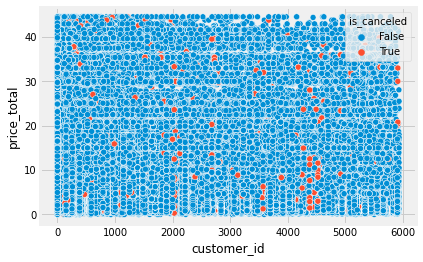

In [19]:
sns.scatterplot(x = "customer_id", y = "price_total", data = train, hue='is_canceled');

In [20]:
# orders_top = orders[orders['price_total'] >= 25000]
# orders_r = orders[orders['price_total'] < 25000]
# orders_rr = orders_r[orders_r['customer_id'].isin(regulars)]
# orders_rn = orders_r[~orders_r['customer_id'].isin(regulars)]

## 2.2. Data loading in time domain

In [21]:
def read_and_parse_data(file_name):
    df = pd.read_hdf('/content/drive/MyDrive/time-series/retail/{}'.format(file_name)).reset_index(drop=True)
    df.index = pd.to_datetime( df['invoice_date'] )
    
    return df


train = read_and_parse_data('train_online_retail.h5')
test = read_and_parse_data('test_online_retail.h5')

# 3. Initial looking at the data from time perspective

In [22]:
train.head(5)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
invoice_date,,,,,,,,,,,
2009-12-01 09:06:00,2,12,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.949219,59.500000,1,United Kingdom,False,False
2009-12-01 09:06:00,2,13,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.449219,98.099998,1,United Kingdom,False,False
2009-12-01 09:06:00,2,14,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.949219,17.850000,1,United Kingdom,False,False
2009-12-01 09:06:00,2,15,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.690430,27.040001,1,United Kingdom,False,False
2009-12-01 09:06:00,2,16,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.949219,20.850000,1,United Kingdom,False,False


In [23]:
train_agg = train.groupby('invoice')[ ['price_total',  'is_canceled'] ].sum()
train_agg['is_canceled'] = train_agg['is_canceled'] > 0
train_agg['total_return'] = train_agg['price_total'] * train_agg['is_canceled']

In [24]:
train_agg.shape

(26814, 3)

In [25]:
train_agg.head(15)

,price_total,is_canceled,total_return
invoice,,,
2,630.330017,False,0.000000
3,310.750000,False,0.000000
4,2286.239990,False,0.000000
5,426.299988,False,0.000000
8,382.369995,False,0.000000
9,285.059998,False,0.000000
10,141.000000,False,0.000000
12,996.100037,False,0.000000
14,570.239990,False,0.000000


---
Left outer Join or Left join pandas is used:

Join in Pandas Merge data frames inner outer right left join in pandas python 7

Return all rows from the left table, and any rows with matching keys from the right table.When there is no Matching from right table NaN will be returned_

In [26]:
left_join_df= pd.merge( train_agg,train, on='invoice', how='left')

In [27]:
left_join_df.shape

(520142, 14)

In [28]:
left_join_df[left_join_df.invoice==15]

,invoice,price_total_x,is_canceled_x,total_return,stock_code,description,quantity,invoice_date,price_unit,price_total_y,customer_id,country,is_canceled_y,is_test
140,15,196.100006,True,196.100006,154,PAPER BUNTING WHITE LACE,12,2009-12-01 10:33:00,2.949219,35.400002,13,Australia,True,False
141,15,196.100006,True,196.100006,155,CREAM FELT EASTER EGG BASKET,6,2009-12-01 10:33:00,1.650391,9.900000,13,Australia,True,False
142,15,196.100006,True,196.100006,156,POTTING SHED SOW 'N' GROW SET,4,2009-12-01 10:33:00,4.250000,17.000000,13,Australia,True,False
143,15,196.100006,True,196.100006,157,POTTING SHED TWINE,6,2009-12-01 10:33:00,2.099609,12.600000,13,Australia,True,False
144,15,196.100006,True,196.100006,137,PAPER CHAIN KIT RETRO SPOT,12,2009-12-01 10:33:00,2.949219,35.400002,13,Australia,True,False
145,15,196.100006,True,196.100006,6,SAVE THE PLANET MUG,12,2009-12-01 10:33:00,1.250000,15.000000,13,Australia,True,False
146,15,196.100006,True,196.100006,158,ANTIQUE SILVER TEA GLASS ETCHED,12,2009-12-01 10:33:00,1.250000,15.000000,13,Australia,True,False
147,15,196.100006,True,196.100006,46,HANGING HEART ZINC T-LIGHT HOLDER,24,2009-12-01 10:33:00,0.850098,20.400000,13,Australia,True,False
148,15,196.100006,True,196.100006,159,PAPER BUNTING RETRO SPOTS,12,2009-12-01 10:33:00,2.949219,35.400002,13,Australia,True,False


remove duplicates by column invoices(loosing info about particular items)


In [29]:
left_join_df= left_join_df.drop_duplicates(subset='invoice', keep="last")

In [30]:
left_join_df[left_join_df.invoice==15]

,invoice,price_total_x,is_canceled_x,total_return,stock_code,description,quantity,invoice_date,price_unit,price_total_y,customer_id,country,is_canceled_y,is_test
148,15,196.100006,True,196.100006,159,PAPER BUNTING RETRO SPOTS,12,2009-12-01 10:33:00,2.949219,35.400002,13,Australia,True,False


## Changing perspective to time domain

In [31]:
def change_persepctive_to_time(df, column):
    df = df.reset_index(drop=True)
    df.index = pd.to_datetime( df[column] )
    return df

In [32]:
column= 'invoice_date' #column where there is information about the time
left_join_df = change_persepctive_to_time(left_join_df, column)

In [33]:
left_join_df.head(15).T

invoice_date,2009-12-01 09:06:00,2009-12-01 09:08:00,2009-12-01 09:24:00,2009-12-01 09:28:00,2009-12-01 09:46:00,2009-12-01 09:50:00,2009-12-01 09:55:00,2009-12-01 10:06:00,2009-12-01 10:18:00,2009-12-01 10:33:00,2009-12-01 10:52:00,2009-12-01 10:52:00,2009-12-01 10:52:00,2009-12-01 10:53:00,2009-12-01 10:55:00
invoice,2,3,4,5,8,9,10,12,14,15,21,22,23,24,25
price_total_x,630.33,310.75,2286.24,426.3,382.37,285.06,141,996.1,570.24,196.1,0,1197.8,0,0,12.6
is_canceled_x,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
total_return,0,0,0,0,0,0,0,0,0,196.1,0,0,0,0,12.6
stock_code,30,52,69,86,107,113,86,149,153,159,130,15,213,91,214
description,SCOTTIE DOG HOT WATER BOTTLE,CHOCOLATE HOT WATER BOTTLE,CHARLIE & LOLA WASTEPAPER BIN FLORA,POSTAGE,VICTORIAN SEWING KIT,RED SPOTTY OVEN GLOVE DOUBLE,POSTAGE,CREAM SWEETHEART MINI CHEST,SILVER APERITIF GLASS,PAPER BUNTING RETRO SPOTS,85123a mixed,ASSORTED COLOUR BIRD ORNAMENT,short,21733 mixed,FELTCRAFT 6 FLOWER FRIENDS
quantity,24,3,60,3,12,6,1,2,48,12,96,160,240,192,6
invoice_date,2009-12-01 09:06:00,2009-12-01 09:08:00,2009-12-01 09:24:00,2009-12-01 09:28:00,2009-12-01 09:46:00,2009-12-01 09:50:00,2009-12-01 09:55:00,2009-12-01 10:06:00,2009-12-01 10:18:00,2009-12-01 10:33:00,2009-12-01 10:52:00,2009-12-01 10:52:00,2009-12-01 10:52:00,2009-12-01 10:53:00,2009-12-01 10:55:00
price_unit,4.25,4.94922,2.40039,18,1.25,2.94922,141,12.75,2.11914,2.94922,0,1.4502,0,0,2.09961
price_total_y,102,14.85,144,54,15,17.7,141,25.5,101.76,35.4,0,232,0,0,12.6




```
Resampling options

pandas comes with many in-built options for resampling, and you can even define your own methods.

In terms of date ranges, the following is a table for common time period options when resampling a time series:
Alias 	Description
B 	Business day
D 	Calendar day
W 	Weekly
M 	Month end
Q 	Quarter end
A 	Year end
BA 	Business year end
AS 	Year start
H 	Hourly frequency
T, min 	Minutely frequency
S 	Secondly frequency
L, ms 	Millisecond frequency
U, us 	Microsecond frequency
N, ns 	Nanosecond frequency

These are some of the common methods you might use for resampling:
Method 	Description
bfill 	Backward fill
count 	Count of values
ffill 	Forward fill
first 	First valid data value
last 	Last valid data value
max 	Maximum data value
mean 	Mean of values in time range
median 	Median of values in time range
min 	Minimum data value
nunique 	Number of unique values
ohlc 	Opening value, highest value, lowest value, closing value
pad 	Same as forward fill
std 	Standard deviation of values
sum 	Sum of values
var 	Variance of values
```



In [34]:
def create_res_df(df_in,  period_option, interval):
  
  df_out='{}_summary'.format(interval)
  name= df_out
  df_out = pd.DataFrame()
  
  df_out['cnt_invoices']= df_in['invoice'].resample(period_option).count()
  df_out['daily_total_return']= df_in['total_return'].resample(period_option).sum()
  df_out['price_total_x']=df_in['total_return'].resample(period_option).sum()
  df_out['price_total_y']=df_in['total_return'].resample(period_option).sum()
  df_out['mean_price_unit']=df_in['price_unit'].resample(period_option).mean()
  df_out['min_price_unit']=df_in['price_unit'].resample(period_option).min()
  df_out['max_price_unit']=df_in['price_unit'].resample(period_option).max()
  df_out['std_price_unit']=df_in['price_unit'].resample(period_option).std()
  df_out['var_price_unit']=df_in['price_unit'].resample(period_option).var()
  df_out['sum_quantity']=df_in['quantity'].resample(period_option).sum()
  df_out['cnt_quantity']=df_in['quantity'].resample(period_option).count()
  df_out['cnt_customer']=df_in['customer_id'].resample(period_option).count()
  df_out['invoice_date']=df_in['invoice_date'].resample(period_option).min()#included as last
  # df_out['country_val'] = pd.factorize(df_in['country'])[0]
  df_out['daily_total_return'].plot(title=name, figsize=(15, 5));


  return df_out


# 4.  Using **10days** period to prepare train and test

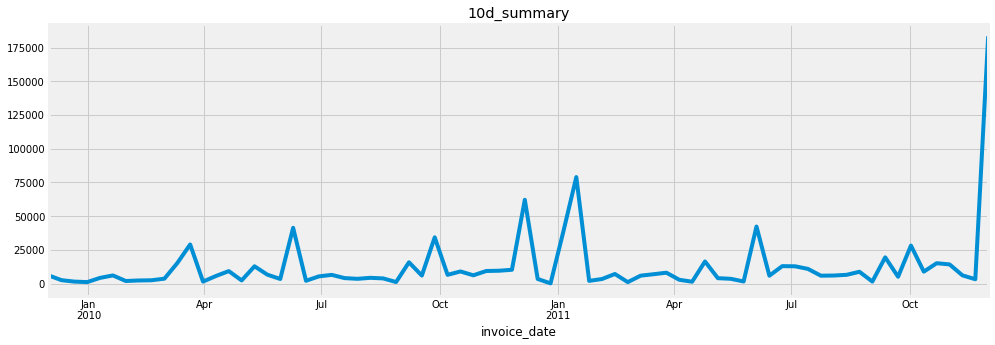

In [35]:
period_option= '10d'
interval= '10d'
df_in=left_join_df
name = create_res_df(df_in,  period_option, interval)

In [36]:
name.head(10)

,cnt_invoices,daily_total_return,price_total_x,price_total_y,mean_price_unit,min_price_unit,max_price_unit,std_price_unit,var_price_unit,sum_quantity,cnt_quantity,cnt_customer,invoice_date
invoice_date,,,,,,,,,,,,,
2009-12-01,606,6121.000000,6121.000000,6121.000000,7.953125,0.0,647.00000,40.529701,1643.00000,19638,606,606,2009-12-01 09:06:00
2009-12-11,418,2589.409912,2589.409912,2589.409912,6.695312,0.0,848.50000,41.762721,1744.00000,13417,418,418,2009-12-11 09:18:00
2009-12-21,153,1526.250000,1526.250000,1526.250000,6.414062,0.0,155.37500,21.647915,468.75000,7186,153,153,2009-12-21 09:00:00
2009-12-31,129,1157.349976,1157.349976,1157.349976,9.171875,0.0,780.50000,68.619020,4708.00000,6925,129,129,2010-01-04 09:24:00
2010-01-10,257,4287.649902,4287.649902,4287.649902,21.015625,0.0,1748.00000,133.807283,17904.00000,6939,257,257,2010-01-10 11:47:00
2010-01-20,381,6101.770020,6101.770020,6101.770020,34.812500,0.0,5116.00000,284.262029,inf,10281,381,381,2010-01-20 08:27:00
2010-01-30,384,1971.339966,1971.339966,1971.339966,9.710938,0.0,608.50000,57.216723,3274.00000,5296,384,384,2010-01-31 10:08:00
2010-02-09,318,2363.169922,2363.169922,2363.169922,12.921875,0.0,1509.00000,101.271961,10256.00000,9749,318,318,2010-02-09 08:38:00
2010-02-19,323,2522.989990,2522.989990,2522.989990,3.636719,0.0,47.84375,5.737657,32.90625,15951,323,323,2010-02-19 09:26:00


There is need to be careful with values, features like inf ( infinite) as those will crask keras

In [37]:
def add_time_feat(df, time_column):
  df['year'] = df[time_column].dt.year
  df['month'] = df[time_column].dt.month
  df['weekday'] = df[time_column].dt.weekday
  df['hour'] = df[time_column].dt.hour

  
  df['week'] = df[time_column].dt.isocalendar().week
  # df['country_val'] = pd.factorize(df['country'])[0]
  return df

In [38]:
time_column='invoice_date'
name= add_time_feat(name, time_column)

In [39]:
name.fillna(value='', inplace=True)

In [41]:
def split_train_test( df, ratio):
  train_size = int(len(df) * ratio)
  test_size = len(df) - train_size
  train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
  print(len(train), len(test))
  return train, test

ratio= 0.7
train, test= split_train_test( name, ratio)

#choosing features
def get_feats(df):
    black_list = ['date', 'country', ' 	is_canceled', 'total_return', 'num_canceled', 'daily_total_return', 'var_price_unit']
    feats = df.select_dtypes(include=[np.number]).columns
    
    feats = [feat for feat in feats if feat not in black_list]
    return feats
feats= get_feats(name)
feats

51 23


['cnt_invoices',
 'price_total_x',
 'price_total_y',
 'mean_price_unit',
 'min_price_unit',
 'max_price_unit',
 'std_price_unit',
 'sum_quantity',
 'cnt_quantity',
 'cnt_customer',
 'year',
 'month',
 'weekday',
 'hour',
 'week']

In [42]:
name.fillna(value='', inplace=True)
ratio= 0.7
train, test= split_train_test( name, ratio)
feats= get_feats(name)
feats

51 23


['cnt_invoices',
 'price_total_x',
 'price_total_y',
 'mean_price_unit',
 'min_price_unit',
 'max_price_unit',
 'std_price_unit',
 'sum_quantity',
 'cnt_quantity',
 'cnt_customer',
 'year',
 'month',
 'weekday',
 'hour',
 'week']

In [ ]:
test.shape, train.shape

## Scaling

In [43]:
def scaling(train, test):
  f_transformer = RobustScaler()
  cnt_transformer = RobustScaler()

  f_transformer = f_transformer.fit(train[feats].to_numpy())
  cnt_transformer = cnt_transformer.fit(train[['daily_total_return']])

  train.loc[:, feats] = f_transformer.transform(train[feats].to_numpy())
  train['daily_total_return'] = cnt_transformer.transform(train[['daily_total_return']])

  test.loc[:, feats] = f_transformer.transform(test[feats].to_numpy())
  test['daily_total_return'] = cnt_transformer.transform(test[['daily_total_return']])
  return train, test

In [ ]:
# f_transformer = RobustScaler()
# cnt_transformer = RobustScaler()

# f_transformer = f_transformer.fit(train[feats].to_numpy())
# cnt_transformer = cnt_transformer.fit(train[['daily_total_return']])

# train.loc[:, feats] = f_transformer.transform(train[feats].to_numpy())
# train['daily_total_return'] = cnt_transformer.transform(train[['daily_total_return']])

# test.loc[:, feats] = f_transformer.transform(test[feats].to_numpy())
# test['daily_total_return'] = cnt_transformer.transform(test[['daily_total_return']])


In [44]:
train, test= scaling(train, test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [45]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[feats], train.daily_total_return, time_steps)
X_test, y_test = create_dataset(test[feats], test.daily_total_return, time_steps)

print(X_train.shape, y_train.shape)

(41, 10, 15) (41,)


## Model

In [46]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

## Training

In [47]:


history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
2/2 [==============================] - 5s 737ms/step - loss: 8.4186 - val_loss: 0.1172
Epoch 2/50
2/2 [==============================] - 0s 36ms/step - loss: 7.4942 - val_loss: 0.1508
Epoch 3/50
2/2 [==============================] - 0s 31ms/step - loss: 7.1927 - val_loss: 0.2108
Epoch 4/50
2/2 [==============================] - 0s 30ms/step - loss: 6.9863 - val_loss: 0.3007
Epoch 5/50
2/2 [==============================] - 0s 33ms/step - loss: 6.7684 - val_loss: 0.4227
Epoch 6/50
2/2 [==============================] - 0s 32ms/step - loss: 6.5337 - val_loss: 0.5696
Epoch 7/50
2/2 [==============================] - 0s 33ms/step - loss: 6.6266 - val_loss: 0.7306
Epoch 8/50
2/2 [==============================] - 0s 32ms/step - loss: 6.4522 - val_loss: 0.8614
Epoch 9/50
2/2 [==============================] - 0s 34ms/step - loss: 6.1444 - val_loss: 0.9411
Epoch 10/50
2/2 [==============================] - 0s 31ms/step - loss: 6.2053 - val_loss: 0.9969
Epoch 11/50
2/2 [===========

## Presenting

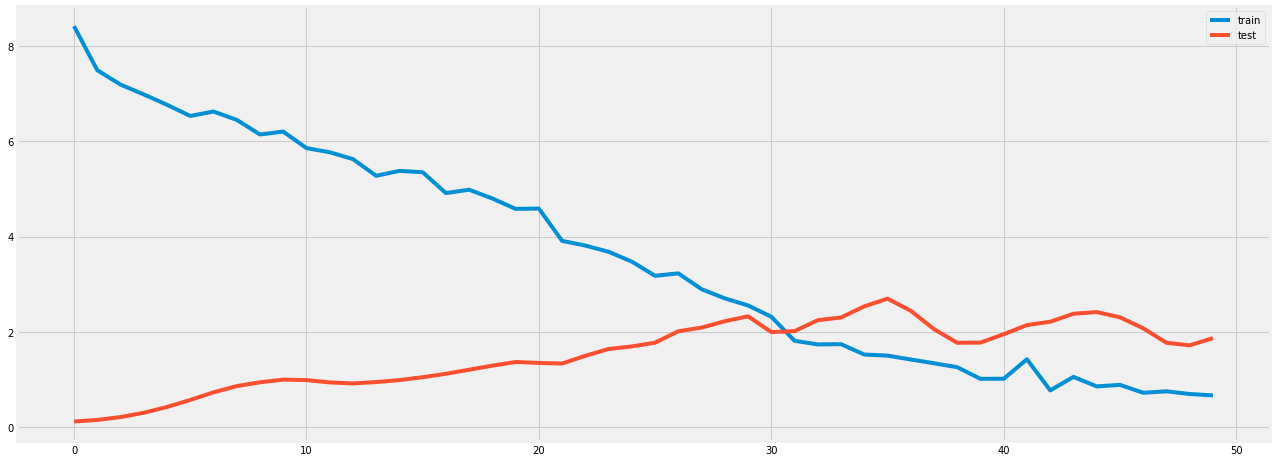

In [48]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();



In [52]:
  f_transformer = RobustScaler()
  cnt_transformer = RobustScaler()
  f_transformer = f_transformer.fit(train[feats].to_numpy())
  cnt_transformer = cnt_transformer.fit(train[['daily_total_return']])

In [53]:
y_pred = model.predict(X_test)

y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)



## How model recognizes trends

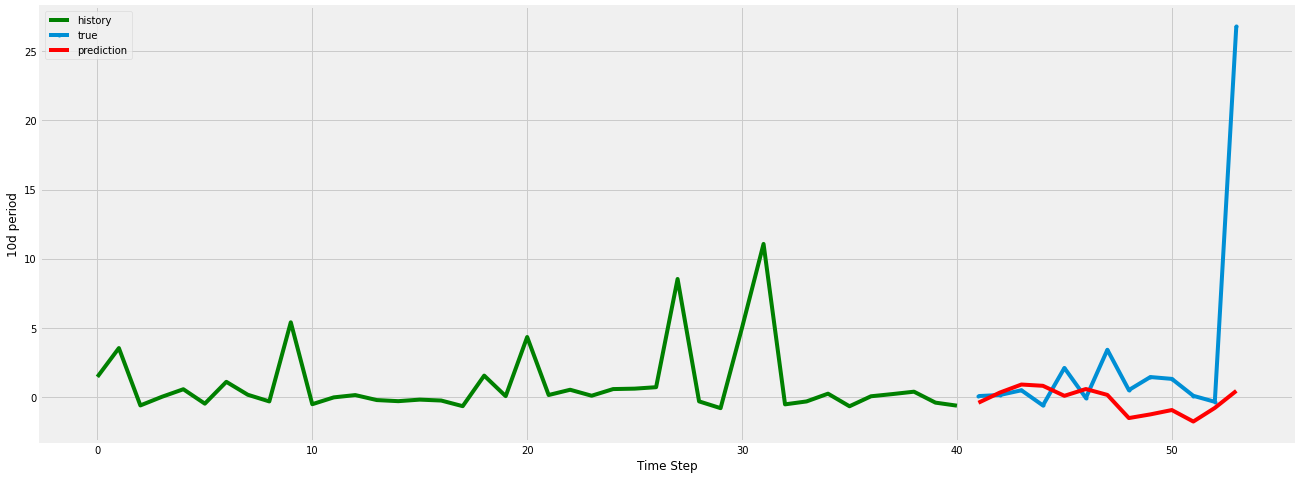

In [54]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")

plt.ylabel('10d period')
plt.xlabel('Time Step')
plt.legend()

plt.show();

# Lets play with model for diffrent time domains

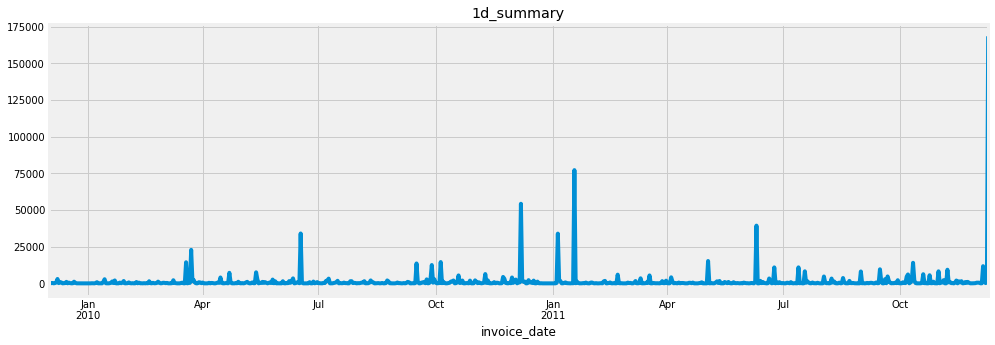

In [120]:
period_option= '1d'
interval= '1d'
df_in=left_join_df
name = create_res_df(df_in,  period_option, interval)

In [121]:
time_column='invoice_date'
name= add_time_feat(name, time_column)

In [122]:
# name.fillna(value='', inplace=True) #explanation https://github.com/nithinmurali/pygsheets/issues/405
name = name.astype('object').fillna('') #zobaczmy czy to pomoglo bo wypelnilo na
ratio= 0.7
train, test= split_train_test( name, ratio)
feats= get_feats(name)
feats

517 222


['cnt_invoices',
 'price_total_x',
 'price_total_y',
 'sum_quantity',
 'cnt_quantity',
 'cnt_customer']

In [123]:
train, test= scaling(train, test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [124]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[feats], train.daily_total_return, time_steps)
X_test, y_test = create_dataset(test[feats], test.daily_total_return, time_steps)

print(X_train.shape, y_train.shape)

(507, 10, 6) (507,)


In [125]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [128]:

history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
15/15 [==============================] - 0s 21ms/step - loss: 92.1993 - val_loss: 9.6171
Epoch 2/100
15/15 [==============================] - 0s 19ms/step - loss: 89.5878 - val_loss: 11.2723
Epoch 3/100
15/15 [==============================] - 0s 19ms/step - loss: 87.3606 - val_loss: 10.1658
Epoch 4/100
15/15 [==============================] - 0s 20ms/step - loss: 87.0215 - val_loss: 11.2506
Epoch 5/100
15/15 [==============================] - 0s 19ms/step - loss: 85.5122 - val_loss: 19.2754
Epoch 6/100
15/15 [==============================] - 0s 20ms/step - loss: 85.8999 - val_loss: 9.0830
Epoch 7/100
15/15 [==============================] - 0s 19ms/step - loss: 83.9681 - val_loss: 13.3432
Epoch 8/100
15/15 [==============================] - 0s 20ms/step - loss: 82.1882 - val_loss: 12.9715
Epoch 9/100
15/15 [==============================] - 0s 19ms/step - loss: 80.6197 - val_loss: 16.1024
Epoch 10/100
15/15 [==============================] - 0s 19ms/step - loss: 76.9451 -

In [114]:
name.columns

Index(['cnt_invoices', 'daily_total_return', 'price_total_x', 'price_total_y',
       'mean_price_unit', 'min_price_unit', 'max_price_unit', 'std_price_unit',
       'var_price_unit', 'sum_quantity', 'cnt_quantity', 'cnt_customer',
       'invoice_date', 'year', 'month', 'weekday', 'hour', 'week'],
      dtype='object')

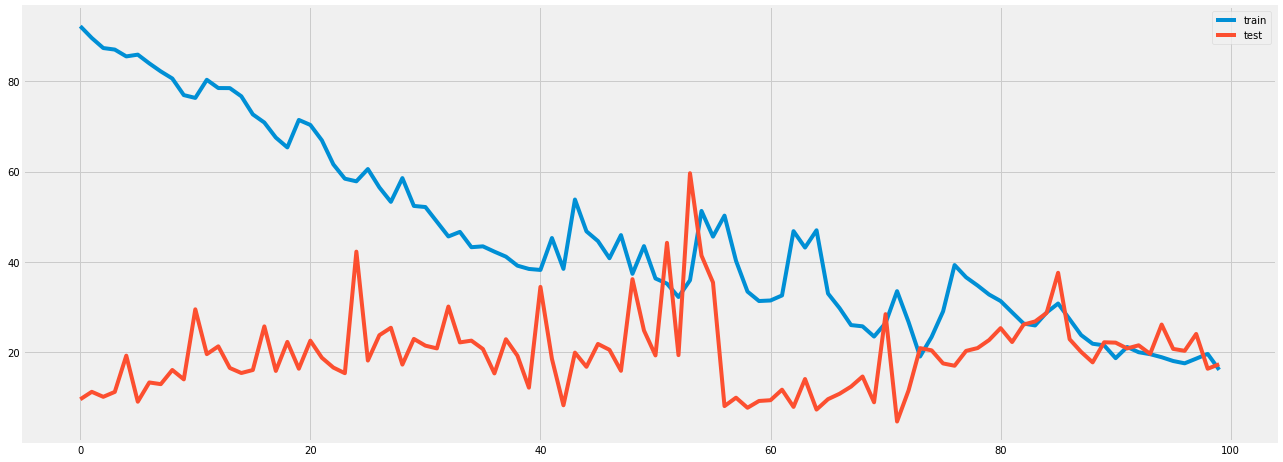

In [129]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

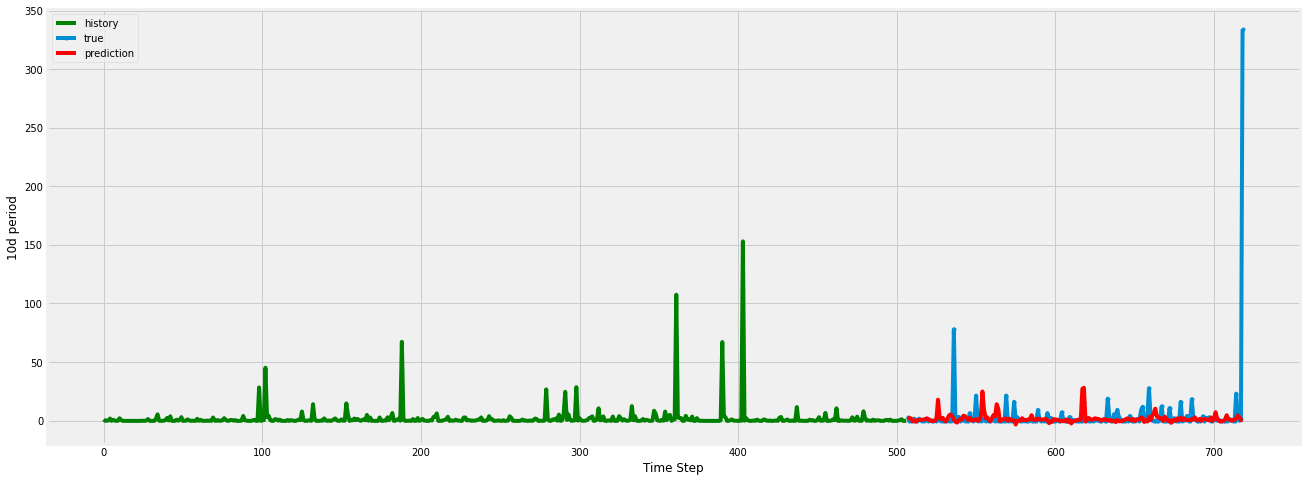

In [130]:
f_transformer = RobustScaler()
cnt_transformer = RobustScaler()
f_transformer = f_transformer.fit(train[feats].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['daily_total_return']])

y_pred = model.predict(X_test)

y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

plt.figure(figsize=(20,8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")

plt.ylabel('1d period')
plt.xlabel('Time Step')
plt.legend()

plt.show();

## lest see how distributed are NA in df

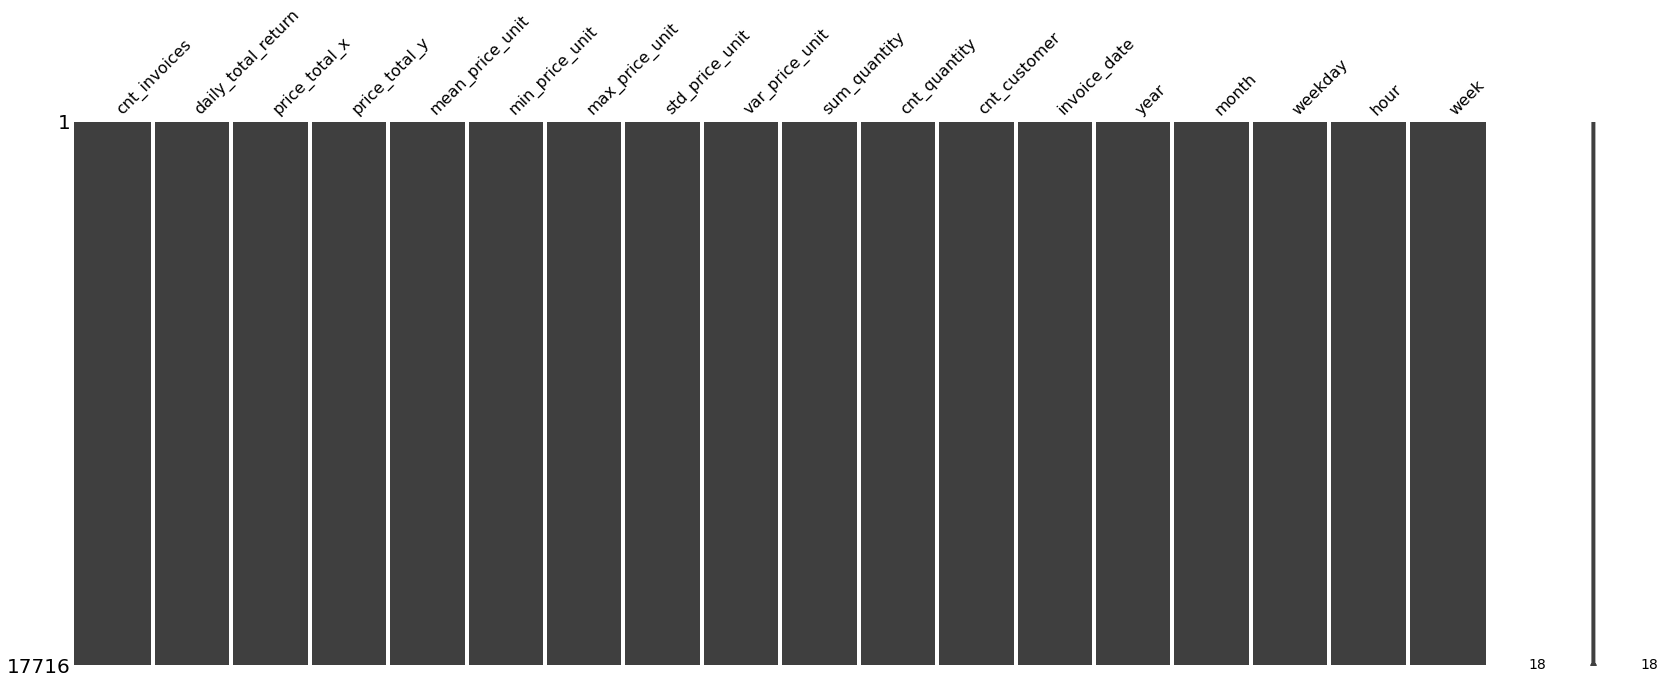

In [70]:
msno.matrix(name)

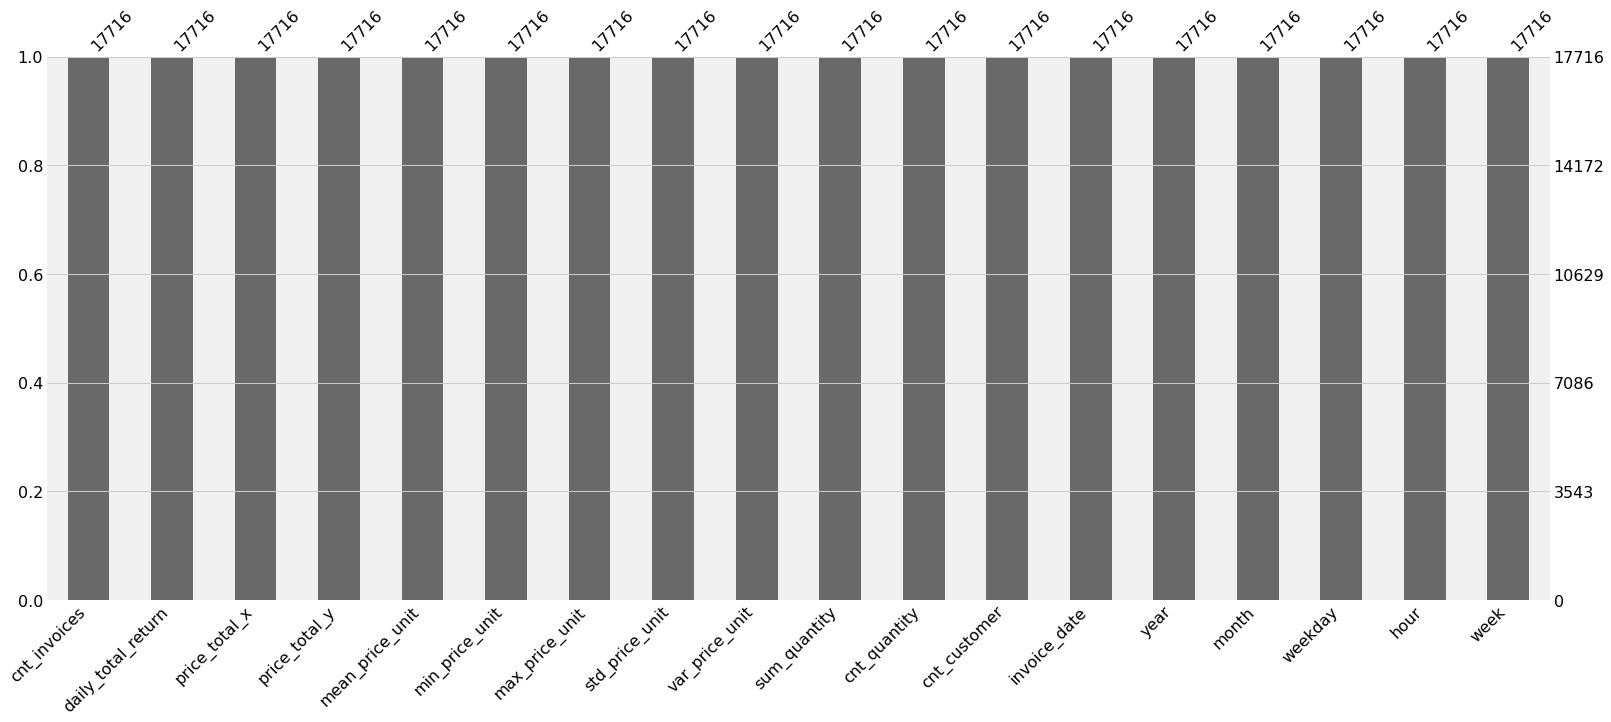

In [71]:
msno.bar(name)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:301: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:301: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


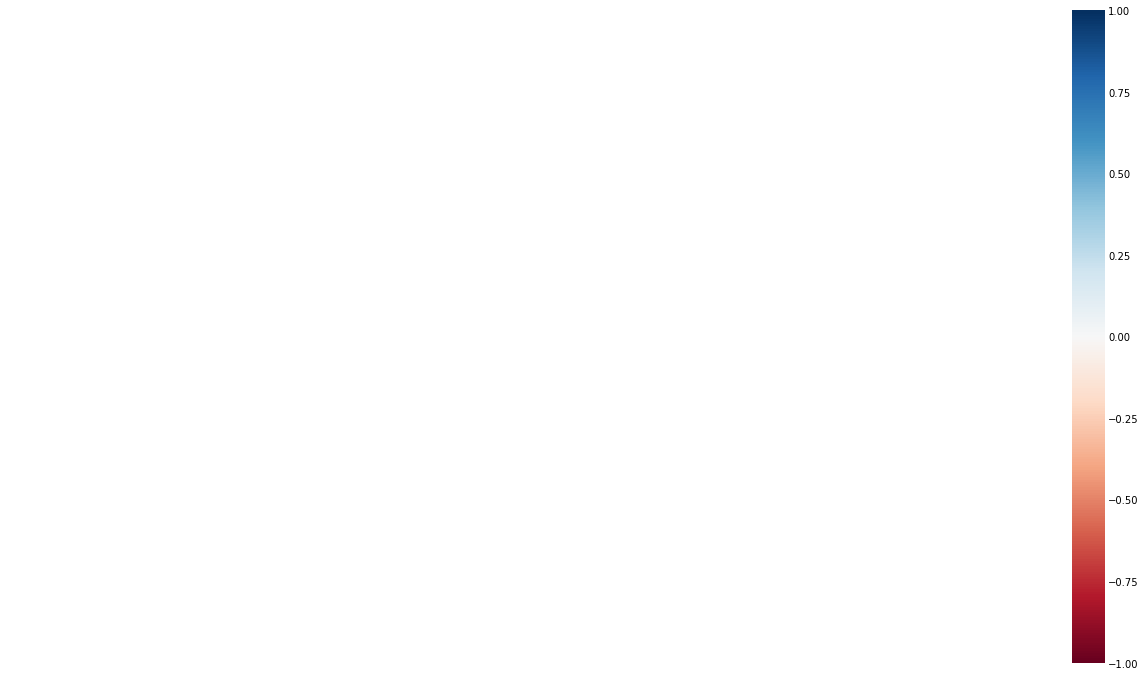

In [72]:
msno.heatmap(name)

# 5. Features generation per an invoice

In [ ]:
orders = train.groupby('invoice').agg(
    num_canceled=('is_canceled', sum), item_num=('price_total', 'count'),
    price_total=('price_total', sum), m_expensive_item_total=('price_total', max),
    item_median_total=('price_total', np.median), l_expensive_item_total=('price_total', min),
    sum_quant=('quantity', sum), great_quant=('quantity', max), least_quent=('quantity', min),
    date=('invoice_date', 'first'), country=('country', 'first'),
    customer_id=('customer_id', 'first'),
    mean_scrat=('stock_code_rat', np.mean), min_scrat=('stock_code_rat', min),
    max_scrat=('stock_code_rat', max),
    mean_sccanc=('stock_code_canc', np.mean), min_sccanc=('stock_code_canc', min),
    max_sccanc=('stock_code_canc', max))

# Time features

orders["date"] = orders['date'].astype("datetime64")
orders['year'] = orders['date'].dt.year
orders['month'] = orders['date'].dt.month
orders['weekday'] = orders['date'].dt.weekday
orders['hour'] = orders['date'].dt.hour


orders['is_canceled'] = orders['num_canceled'] > 0
orders['total_return'] = orders['price_total'] * orders['is_canceled']

orders['country_val'] = pd.factorize(orders['country'])[0]
orders['week'] = orders['date'].dt.isocalendar().week

In [ ]:
orders.sample(10).T

invoice,19479,19495,48858,27715,17096,28678,22973,18203,7914,19046
num_canceled,0,0,0,1,0,0,0,0,0,0
item_num,19,12,3,1,33,26,13,1,31,77
price_total,229.17,385.9,70.68,3.75,340.59,1313.4,256.83,15.6,84.37,355.71
m_expensive_item_total,50.98,87,45,3.75,64.17,153,62.4,15.6,9.9,20.65
item_median_total,6.72,18.15,18.72,3.75,5.91,47.7,15.8,15.6,1.95,3.3
l_expensive_item_total,0.81,10.5,6.96,3.75,0.85,17.4,9.95,15.6,0.55,0.55
sum_quant,25,252,108,3,40,300,203,8,37,224
great_quant,4,50,48,3,4,18,96,8,4,25
least_quent,1,2,24,3,1,6,1,8,1,1
date,2010-09-13 12:26:00,2010-09-13 13:09:00,2011-10-28 09:29:00,2010-11-30 16:40:00,2010-08-04 16:11:00,2010-12-09 12:49:00,2010-10-19 16:56:00,2010-08-22 14:56:00,2010-03-26 14:01:00,2010-09-06 12:55:00


## Second time looking at the data tabular and charts

In [ ]:
agg_funcs = [np.mean, np.median, np.std, np.size]
pd.pivot_table(orders, index=["month","year"], values=["total_return"], aggfunc=agg_funcs)

mean       median          std         size
           total_return total_return total_return total_return
month year                                                    
1     2010    14.475306          0.0   104.148738        801.0
      2011   170.007050          0.0  3042.678268        703.0
2     2010     6.871393          0.0    50.383111        991.0
      2011    16.771799          0.0   210.115179        678.0
3     2010    40.378967          0.0   523.967188       1191.0
      2011    17.466459          0.0   189.084613       1017.0
4     2010    17.555069          0.0   212.074775        945.0
      2011    11.039572          0.0   143.488364        888.0
5     2010    17.766338          0.0   176.002425       1226.0
      2011    22.824549          0.0   333.246634       1053.0
6     2010    43.514210          0.0   776.990527       1107.0
      2011    61.364063          0.0  1255.153975       1002.0
7     2010    15.608255          0.0   127.406761        986.0
      2011    27.081673          0.0   302.100326        933.0
8     2010    11.921511          0.0    99.928020        953.0
      2011    30.324598          0.0   282.825605        859.0
9     2010    34.983311          0.0   481.009191       1193.0
      2011    22.054871          0.0   268.779700       1189.0
10    2010    21.984491          0.0   311.559691       1505.0
      2011    39.436432          0.0   454.447252       1326.0
11    2010    14.891657          0.0   159.637411       1865.0
      2011    13.799732          0.0   213.063673       1718.0
12    2009     8.697248          0.0    60.194832       1177.0
      2010    70.787994          0.0  1017.349866       1008.0
      2011   366.767181          0.0  7550.731025        500.0

## Lets put some keras into acton and time series based on orders where there are plenty of features

## changing domain to time

In [ ]:
def change_persepctive_to_time(df, column):
    df = orders.reset_index(drop=True)
    df.index = pd.to_datetime( df[column] )
    return df


In [ ]:
column= 'date' #column where there is information about the time
orders = change_persepctive_to_time(orders, column)

In [ ]:
orders.sample(4)

,num_canceled,item_num,price_total,m_expensive_item_total,item_median_total,l_expensive_item_total,sum_quant,great_quant,least_quent,date,country,customer_id,mean_scrat,min_scrat,max_scrat,mean_sccanc,min_sccanc,max_sccanc,year,month,weekday,hour,is_canceled,total_return,country_val,week
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-02 16:18:00,0,1,0.000000,0.000000,0.00,0.00,7,7,7,2010-03-02 16:18:00,United Kingdom,-1,0.000000,0.000000,0.000000,0.000000,0,0,2010,3,1,16,False,0.000000,0,9
2011-02-04 11:22:00,2,2,46.200001,23.100000,23.10,23.10,28,14,14,2011-02-04 11:22:00,United Kingdom,-1,0.018667,0.014925,0.022409,5.500000,3,8,2011,2,4,11,True,46.200001,0,5
2010-02-21 14:57:00,0,20,160.190002,23.799999,8.40,1.25,74,8,1,2010-02-21 14:57:00,United Kingdom,567,0.014686,0.000000,0.089888,10.050000,0,75,2010,2,6,14,False,0.000000,0,7
2010-12-16 17:53:00,0,15,357.940002,75.599998,20.16,4.56,386,48,4,2010-12-16 17:53:00,United Kingdom,759,0.019293,0.000000,0.068111,4.333333,0,44,2010,12,3,17,False,0.000000,0,50


## total return will be our target  befo there is need for some regularisation


```
orders['total_return']
```




Based on subplots there are some information to get from data

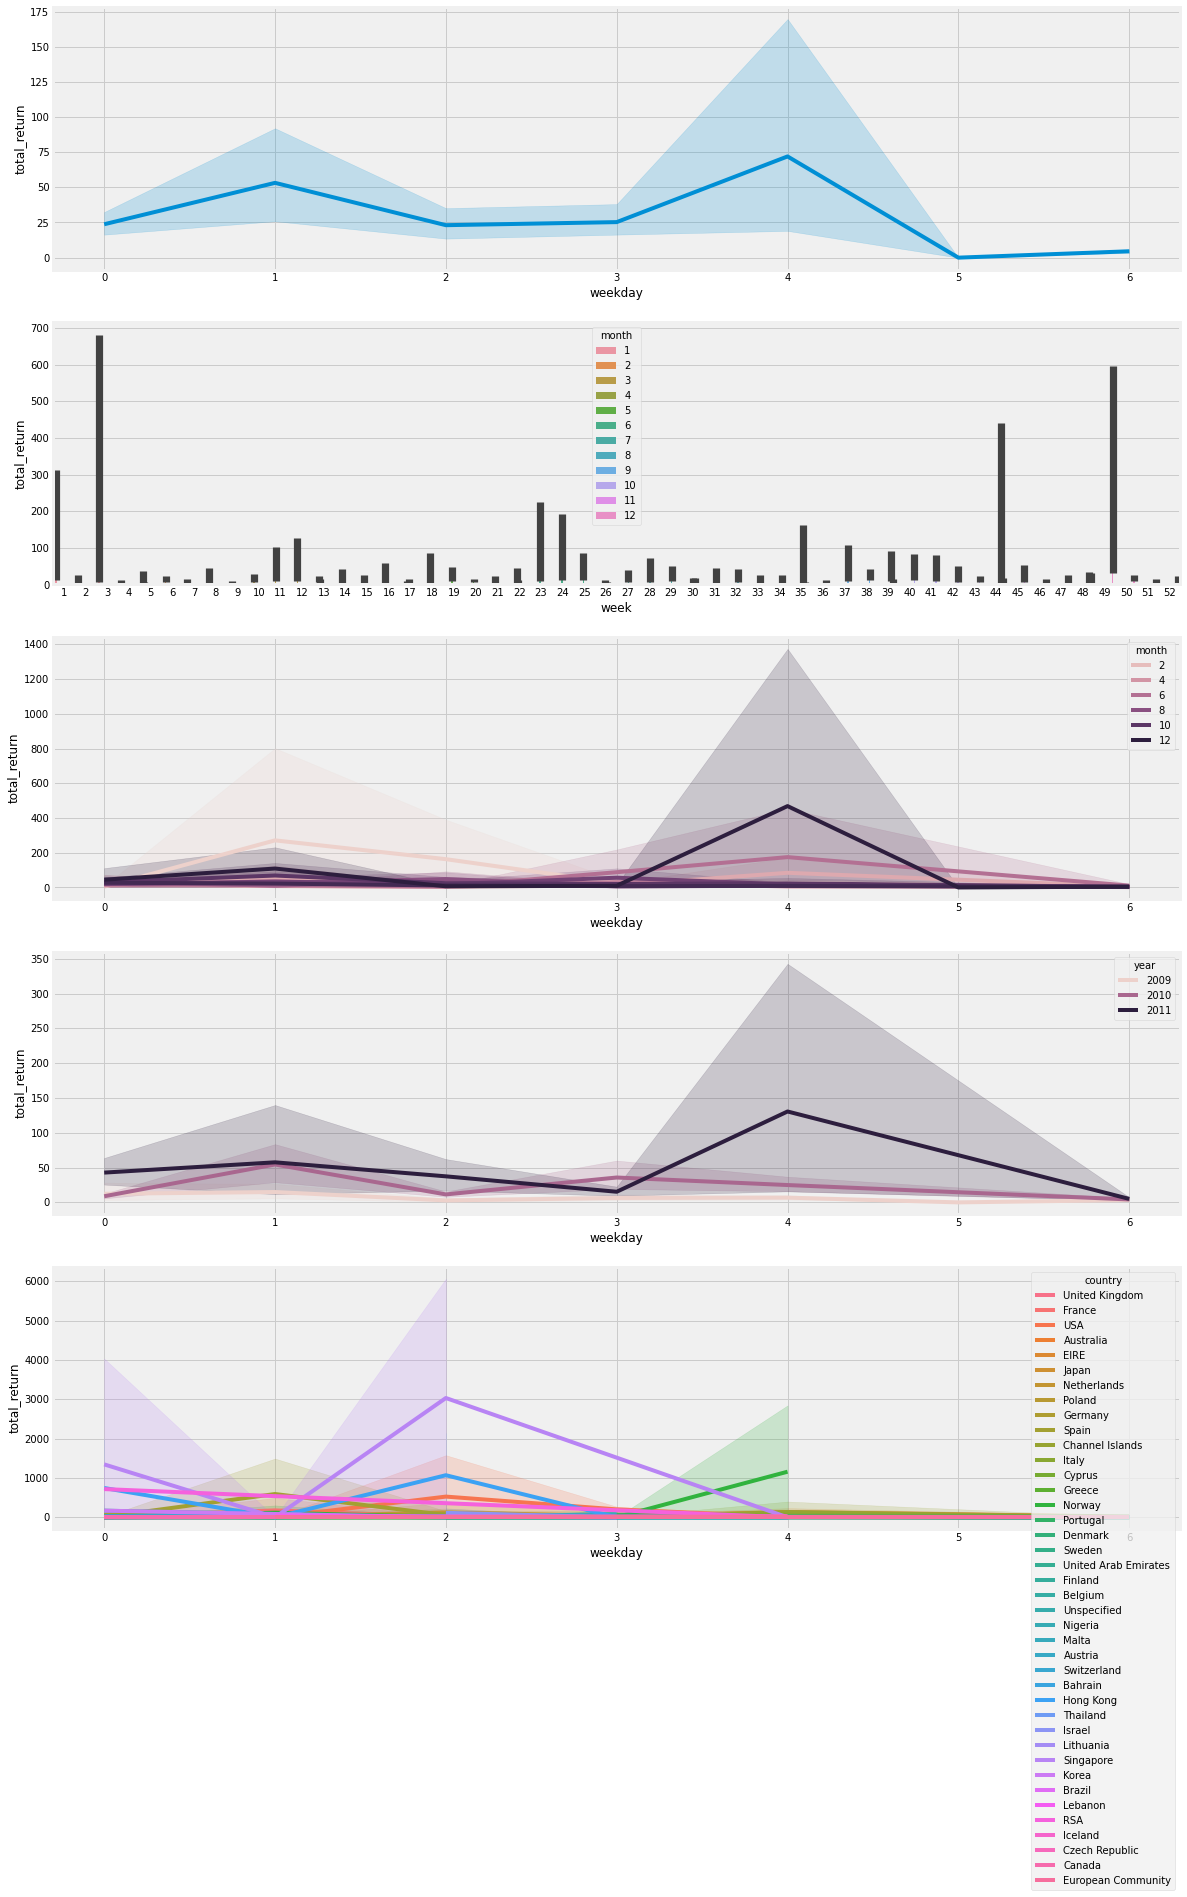

In [ ]:
fig,(ax1, ax2, ax3, ax4, ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18, 28)

sns.lineplot(data=orders, x='weekday', y='total_return', ax=ax1)
sns.barplot(data=orders, x='week', y='total_return', hue='month', ax=ax2)
sns.lineplot(data=orders, x='weekday', y='total_return', hue='month', ax=ax3)
sns.lineplot(data=orders, x='weekday', y='total_return', hue='year', ax=ax4)
sns.lineplot(data=orders, x='weekday', y='total_return', hue='country', ax=ax5);